In [7]:
%%capture
import sys

is_in_colab = 'google.colab' in sys.modules

if is_in_colab:
  from google.colab import drive
  drive.mount('/content/drive')

  %cd /content/drive/MyDrive/KU_NLP
  !pip install -r requirements.txt

# 2. Representation Learning

In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from enum import Enum

from models.answer_exists_models import *

import fasttext
import fasttext.util


import torch
from torch import nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import compress_fasttext
from torch.utils.data import Dataset, DataLoader

In [2]:
!pip install compress-fasttext

In [45]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [46]:
class Annotation_error(Enum):
    UNANSWERED = -1
    BAD_TOKENIZATION_OR_DATA = -2
    IGNORED = -3

In [47]:
path_train_set = "data/train_set_stanza.pkl"
path_validation_set = "data/validation_set_stanza.pkl"

In [48]:
train_set = pd.read_pickle(path_train_set)
validation_set = pd.read_pickle(path_validation_set)

In [49]:
train_en = train_set[train_set["language"] == "english"]
train_fi = train_set[train_set["language"] == "finnish"]
train_ja = train_set[train_set["language"] == "japanese"]

validation_en = validation_set[validation_set["language"] == "english"]
validation_fi = validation_set[validation_set["language"] == "finnish"]
validation_ja = validation_set[validation_set["language"] == "japanese"]

# 2a.

In [50]:
train_en

,language,question,document_title,document,document_answer_region
0,english,"[When, was, quantum, field, theory, developed, ?]","[Quantum, field, theory]","[Quantum, field, theory, naturally, began, wit...","(26, 26)"
1,english,"[Who, was, the, first, Nobel, prize, winner, f...","[List, of, Nobel, laureates, in, Literature]","[The, Nobel, Prize, in, Literature, (, Swedish...","(12, 13)"
2,english,"[When, is, the, dialectical, method, used, ?]",[Dialectic],"[Dialectic, or, dialectics, (, Greek, :, διαλε...","(27, 49)"
3,english,"[Who, invented, Hangul, ?]","[Origin, of, Hangul]","[Hangul, was, personally, created, and, promul...","(16, 18)"
4,english,"[What, do, Grasshoppers, eat, ?]",[Grasshopper],"[Grasshoppers, are, plant, -, eaters, ,, with,...","(1, 37)"
...,...,...,...,...,...
7384,english,"[What, was, Neil, Brooks, ', fastest, recorded...","[Swimming, at, the, 1980, Summer, Olympics, –,...","[The, medley, relay, was, scheduled, in, the, ...",Annotation_error.UNANSWERED
7385,english,"[Who, are, the, three, most, important, easter...","[Eastern, philosophy]","[Sāmkhya, is, a, dualist, philosophical, tradi...",Annotation_error.UNANSWERED
7386,english,"[Who, was, costume, designer, for, the, first,...","[John, Mollo]","[Mollo, was, surprised, by, the, success, of, ...",Annotation_error.UNANSWERED
7387,english,"[Who, developed, the, first, thermonuclear, we...","[History, of, nuclear, weapons]","[In, the, end, ,, President, Truman, made, the...",Annotation_error.UNANSWERED


In [51]:
# If the question is answered, then predict "1". Otherwise predict "0".
def get_target(data):
    answer_set = data['document_answer_region']
    y = np.empty(answer_set.shape[0], dtype=np.int32)

    for i, answer in enumerate(answer_set):
        if type(answer) == Annotation_error and answer == Annotation_error.UNANSWERED: # @TODO: if we don't do the annotation stuff, then we can check for -1 here
            y[i] = 0
        else:
            y[i] = 1
    return y

In [116]:
def collate_batch(raw_batch): #-> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Combines multiple data samples into a single batch
    :param input_data: The combined input_ids, seq_lens, and labels for the batch
    :return: A tuple of tensors (input_ids, seq_lens, labels)
    """
    
    global pad_id # @TODO: cleanup
    
    targets = [sample[2] for sample in raw_batch]
    sequence_lengths = [sample[1] for sample in raw_batch]
    
    max_length = max(sequence_lengths)
    
    # Pad all of the input samples to the max length
    token_ids = [(sample[0] + [pad_id] * (max_length - len(sample[0]))) for sample in raw_batch]
    
    # Make sure each sample is max_length long
    assert (all(len(i) == max_length for i in token_ids))
    
    return torch.tensor(token_ids), torch.tensor(sequence_lengths), torch.tensor(targets, dtype=torch.long)


In [117]:
def token_to_id(token, tok2vec):
    global OOV_id # @TODO: cleanup
    
    try:
        id = tok2vec.get_index(token)
    except:
        id = OOV_id # OOV
    return id

In [118]:
def prepare_sample(question_tokens, tok2vec, max_length=512):
    token_ids = [token_to_id(token, tok2vec) for token in question_tokens[:max_length]]
    return token_ids, len(token_ids)

In [119]:
class QuestionAnsweredDatasetReader(Dataset):
    
    def __init__(self, df, tok2vec):
        self.df = df
        self.tok2vec = tok2vec
        self.targets = get_target(df)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.values[idx]
        question_tokens = row[1]
        target = self.targets[idx]
        
        token_ids, seq_length = prepare_sample(question_tokens, self.tok2vec)
        
        return token_ids, seq_length, target

In [120]:
reader = QuestionAnsweredDatasetReader(train_en, tok2vec)

In [121]:
reader[0]

([264, 22, 9677, 765, 2080, 1247, 41], 7, 1)

In [122]:
train_dataset = QuestionAnsweredDatasetReader(train_en[:100], tok2vec)

batch_size=8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

In [169]:
class TinyNetwork1(nn.Module):

    def __init__(self, pretrained_embeddings: torch.tensor, n_classes: int = 2):
        super(TinyNetwork1, self).__init__()

        self.net = nn.Sequential(
            nn.Embedding.from_pretrained(pretrained_embeddings),
            nn.Linear(pretrained_embeddings.shape[1], n_classes),
            nn.Softmax(dim=0)
        )
        
    def forward(self, inputs):
        return self.net.forward(inputs)

In [170]:
class TinyNetwork2(nn.Module):

    def __init__(self, pretrained_embeddings: torch.tensor, lstm_dim: int = 100, n_classes: int = 2):
        super(TinyNetwork2, self).__init__()

        self.lstm_dim = lstm_dim
        self.n_classes = n_classes
        
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.biLSTM = nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(2*lstm_dim, n_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, inputs, input_lengths):
        # b x sl x emb_dim
        embeds = self.embedding(inputs)
    
        # Pack padded: This is necessary for padded batches input to an RNN
        lstm_in = nn.utils.rnn.pack_padded_sequence(embeds, input_lengths, batch_first=True, enforce_sorted=False)
        
        # Pass the packed sequence through the BiLSTM
        lstm_out, _hidden = self.biLSTM(lstm_in)

        # Unpack the packed sequence (b x sl x 2*lstm_dim)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        # representation of the last lstm unit (b x 2*lstm_dim)
        n_batch = lstm_out.shape[0]
        input_ends = input_lengths-1
        ff_in = torch.vstack([lstm_out[i, input_ends[i], :] for i in range(n_batch)])
        # Alternative: Max element-wise over all hidden units
        # ff_in = torch.max(lstm_out, 1)[0]
        
        # Get logits (b x n_classes)
        logits = self.linear(ff_in)
        
        return self.softmax(logits)

In [140]:
# b1: [.1, .4, .6], [.!, .!, .!], [.0, .0, .0], [.0, .0, .0],
# b2: [.1, .4, .6], [.1, .4, .6], [.!, .!, .!], [.0, .0, .0],
# b3: [.1, .4, .6], [.1, .4, .6], [.1, .4, .6], [.!, .!, .!],

In [141]:
a = torch.tensor([[[1,2],[2,3],[6,4],[4,5]], [[5,6],[6,7],[7,8],[8,9]]])
indices = [0, 2]
torch.vstack([a[i,indices[i],:] for i in range(len(indices))])

tensor([[1, 2],
        [7, 8]])

In [142]:
def prepare_embedding_matrix(embed_matrix):
    embed_dim = embed_matrix.shape[1]
    pad = torch.zeros(embed_dim, dtype=torch.float32)
    OOV = torch.zeros(embed_dim, dtype=torch.float32)
    embed_pre = (torch.tensor(embed_matrix, dtype=torch.float32))
    
    pad_id = embed_pre.shape[1]
    OOV_id = embed_pre.shape[1] + 1           
                 
    return torch.vstack((embed_pre, pad, OOV)), pad_id, OOV_id

In [162]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [174]:
tok2vec = compress_fasttext.models.CompressedFastTextKeyedVectors.load("fasttext-en-mini")
pretrained_embeddings, pad_id, OOV_id = prepare_embedding_matrix(tok2vec.get_normed_vectors())

model = TinyNetwork2(pretrained_embeddings)
model.to(device)
print(model)

TinyNetwork2(
  (embedding): Embedding(20002, 300)
  (biLSTM): LSTM(300, 100, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=200, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)


In [175]:
# Test the forward pass with dummy data
inputs = torch.tensor([[42, 1, 8, 0]], dtype=torch.int)
input_lengths = torch.tensor([3], dtype=torch.int)
out = model.forward(inputs, input_lengths)

print("Output shape:", out.size())
print(f"Output probabilities:\n{out.detach().numpy()}")

Output shape: torch.Size([1, 2])
Output probabilities:
[[0.52015305 0.47984695]]


In [183]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [184]:
batch_size = 64
num_epochs = 10

train_dataset = QuestionAnsweredDatasetReader(train_en, tok2vec)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

print(len(train_dataloader))

116


Epoch 1/5
Accuracy: 0.48
Epoch 2/5
Accuracy: 0.45
Epoch 3/5
Accuracy: 0.55
Epoch 4/5
Accuracy: 0.48
Epoch 5/5
Accuracy: 0.45
Finished training.


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

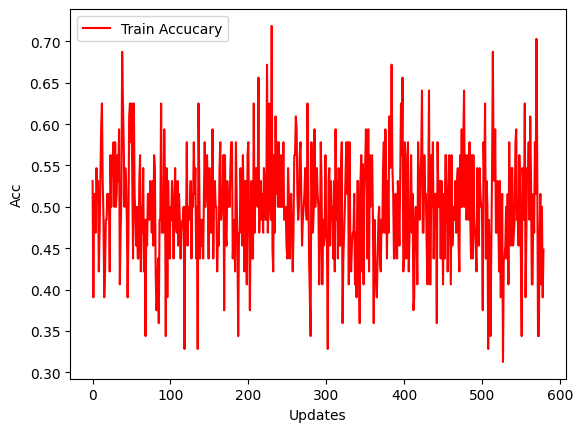

In [185]:
batch_size = 64
num_epochs = 5

train_dataset = QuestionAnsweredDatasetReader(train_en, tok2vec)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

train_accuracies = []
valid_accuracies = []

train_acc = []

for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch+1, num_epochs))
    
    for token_ids, sequence_lengths, targets in train_dataloader:
        model.train()
        
        # Forward pass.
        outputs = model(token_ids, sequence_lengths)
        loss = loss_fn(outputs, targets)

        # Backward pass.
        optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Do prediction
        predictions = outputs.max(1)[1]

        accuracy = accuracy_score(targets, predictions)
        train_acc.append(accuracy)
          
    print("Accuracy: {:.2f}".format(accuracy))
        

print("Finished training.")

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')


In [186]:
num_epochs = 10

train_sentences = torch.tensor([[42, 1, 0], [42, 1, 0], [18, 14, 0], [18, 1, 2]], dtype=torch.int32)
train_lengths = torch.tensor([2, 2, 2, 3], dtype=torch.int32)
train_target = torch.tensor([1, 1, 0, 0])

step = 0
model.train()

train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    inputs = train_sentences
    lengths = train_lengths
    targets = train_target
    
    # Forward pass.
    outputs = model(inputs, lengths)
    loss = loss_fn(outputs, targets)
    
    # Backward pass.
    optimizer.zero_grad()
    loss.backward()
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    step += 1

    # Compute accuracy.
    predictions = outputs.max(1)[1]
    
    #print(outputs)
    #print(predictions)
    
    print("accuracy: {}".format(accuracy_score(targets, predictions)))
        

print("Finished training.")


accuracy: 0.5
accuracy: 0.5
accuracy: 0.5
accuracy: 0.5
accuracy: 0.5
accuracy: 0.5
accuracy: 0.5
accuracy: 0.5
accuracy: 0.5
accuracy: 0.5
Finished training.


# Prepare data

# Model

# 2b.

In [ ]:
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
ft.get_dimension()
ft.get_word_vector('king').shape

fasttext.util.reduce_model(ft, 80)
ft.get_dimension()

"asdasdsad" in ft.words
ft.get_nearest_neighbors('cookie')

In [1]:
import spacy

In [2]:
nlp = spacy.load('en_core_web_md')

In [30]:
nlp.vocab["old"].vector.shape

(300,)

In [4]:
help(nlp)

Help on English in module spacy.lang.en object:

class English(spacy.language.Language)
 |  English(vocab: Union[spacy.vocab.Vocab, bool] = True, *, max_length: int = 1000000, meta: Dict[str, Any] = {}, create_tokenizer: Union[Callable[[ForwardRef('Language')], Callable[[str], spacy.tokens.doc.Doc]], NoneType] = None, batch_size: int = 1000, **kwargs) -> None
 |  
 |  A text-processing pipeline. Usually you'll load this once per process,
 |  and pass the instance around your application.
 |  
 |  Defaults (class): Settings, data and factory methods for creating the `nlp`
 |      object and processing pipeline.
 |  lang (str): IETF language code, such as 'en'.
 |  
 |  DOCS: https://spacy.io/api/language
 |  
 |  Method resolution order:
 |      English
 |      spacy.language.Language
 |      builtins.object
 |  
 |  Data and other attributes defined here:
 |  
 |  Defaults = <class 'spacy.lang.en.EnglishDefaults'>
 |      Language data defaults, available via Language.Defaults. Can be


https://github.com/pytorch/text/issues/1350
https://christopher5106.github.io/deep/learning/2020/04/02/fasttext_pretrained_embeddings_subword_word_representations.html

In [37]:
import compress_fasttext
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from compress_fasttext.feature_extraction import FastTextTransformer

small_model = compress_fasttext.models.CompressedFastTextKeyedVectors.load('fasttext-en-mini')

classifier = make_pipeline(
    FastTextTransformer(model=small_model), 
    LogisticRegression()
).fit(
    ['banana', 'soup', 'burger', 'car', 'tree', 'city'],
    [1, 1, 1, 0, 0, 0]
)
classifier.predict(['jet', 'train', 'cake', 'apple'])
# array([0, 0, 1, 1])

array([0, 0, 1, 1])

In [38]:
help(small_model)

Help on CompressedFastTextKeyedVectors in module compress_fasttext.compress object:

class CompressedFastTextKeyedVectors(gensim.models.fasttext.FastTextKeyedVectors)
 |  CompressedFastTextKeyedVectors(*args, **kwargs)
 |  
 |  This class extends FastTextKeyedVectors by fixing several issues:
 |  - index2word of a freshly created model is initialized from its vocab
 |  - the model does not keep heavy and useless vectors_ngrams_norm
 |  - word_vec() method with use_norm applies normalization in the right place
 |  
 |  Method resolution order:
 |      CompressedFastTextKeyedVectors
 |      gensim.models.fasttext.FastTextKeyedVectors
 |      gensim.models.keyedvectors.KeyedVectors
 |      gensim.utils.SaveLoad
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      Vectors and vocab for :class:`~gensim.models.fasttext.FastText`.
 |      
 |      Implements significant parts of the FastText algorithm.  For example,
 |      the :func:`word_ve

In [70]:
small_model.get_normed_vectors().shape

(20000, 300)

In [71]:
small_model.get_index("slap")

15784

In [82]:
small_model.most_similar("quantum")

[('Quantum', 0.5923356945161),
 ('physics', 0.4987263608889812),
 ('computational', 0.4833229306372649),
 ('cosmic', 0.46287664812730667),
 ('atomic', 0.4555259364535978),
 ('atoms', 0.4543258391303013),
 ('electron', 0.4415847215404407),
 ('electromagnetic', 0.4342020722504953),
 ('optical', 0.4341506741975586),
 ('physicist', 0.43388256332181196)]

In [83]:
small_model["sailor"].shape

(300,)